### 0 - Imports and PATH defining

In [1]:
# IMPORTS

import json, os
import itertools

from helpers.pc2dem import generate_dem_from_dict_v2, generate_chm, detect_best_by_number
from helpers.pc2dem import generate_dem_from_path, single_rband_visualizer, change_tiff_name

import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
# PATHS

# code/ is where my notebooks are
# /pipeline is the folder that contains json files

# base of the bases' folders 
# ROOT: project folder's path
# OUTPUT: related results of dtm/dem - dsm
# SAMPLES : contains base data which is .laz
ROOT = "/home/metin/Desktop/workshop/carbon/carbon.v5"
OUTPUT = "outputs"
SAMPLES = "samples"

PNG_PATH = "png"

OUTPUT_PATH = os.path.join(
    ROOT, OUTPUT
)

### 1 - DTM GENERATION

Getting Needed JSON Pipelines

In [3]:
# Loading our DTM pipeline.

dtm_json = os.path.join(
    "/home/metin/Desktop/workshop/carbon/carbon.v5/code/pipelines/",
    "dtm.json"
)
f_terrain = open(dtm_json)
dtm_data = json.load(f_terrain)
dtm_pipeline = dtm_data["pipeline"]


os.path.exists(dtm_json)

True

We should optimize some parameters before going further, params of specific algorithms.
Since I experimented some values for every parameter, I'll simply stick to them. 

Purpose of this part that I want to show how you can semi-manually optimize the parameter.

Dictionary of the Values of Parameters to Optimize

In [13]:
# Good to note that this dictionary is the list of 
# values of parameters that I want to optimize.
# Not the dictionary that I will use for optimization step
param_dict_list = {
    # Fixed Values
    "input_path":["/home/metin/Desktop/workshop/carbon/carbon.v5/samples/Porirua City Council, Toitū Te Whenua Land Information New Zealand (LINZ) (2023). Porirua, Wellington, New Zealand 2023 (GREATER).laz"],
    
    # will change for every combination values 
    "filename":["/home/metin/Desktop/workshop/carbon/carbon.v5/outputs"],
    
    # Labeling Algorithm Params
    "slope":["0.10", "0.30"],
    "window": ["16"],
    "threshold":["0.50"],
    "scalar": ["1.25"],
    "returns": ["first, only"],
    
    # writers params
    "output_type": ["idw"],
    "window_size": [1],
}

In [14]:
parts = dtm_pipeline[::-1][1:3]
print("This is the pipeline's part\n we have that we want to change . . . ")
print(json.dumps(parts, indent=4))

This is the pipeline's part
 we have that we want to change . . . 
[
    {
        "type": "writers.gdal",
        "filename": "/home/metin/Desktop/workshop/carbon/carbon.v5/outputs/dtm/DTM-0.tif",
        "gdaldriver": "GTiff",
        "output_type": "idw",
        "window_size": 1,
        "resolution": "0.5"
    },
    {
        "type": "filters.smrf",
        "ignore": "Classification[7:7]",
        "slope": "0.10",
        "window": "16",
        "threshold": "0.50",
        "scalar": "1.25",
        "returns": "first, only"
    }
]


In [15]:
for index,combination in enumerate(itertools.product(*param_dict_list.values())):
    one_combination = {}
    for param_name, param_value in zip(param_dict_list.keys(), combination):
        one_combination[param_name] = param_value
        # Process or store the current parameter combination
        #print(json.dumps(one_combination, indent=4))
        name = "DTM-"+str(index)+".tif"
        output_path_ = os.path.join(
            param_dict_list["filename"][0],"dtm" ,name
        )
        # We set the input_path to the point cloud that we'll use in pipeline
        dtm_pipeline[0] = one_combination["input_path"]
    
        for Index, i in enumerate(parts):
            for j in i.keys():
                if j in one_combination.keys():
                    if j == "filename":
                        parts[Index][j] = output_path_
                    else:
                        parts[Index][j] = one_combination[j]

            dtm_pipeline[::-1][1:3] = parts
            dtm_data["pipeline"] = dtm_pipeline
    
    # Generation Part
    generate_dem_from_dict_v2(pipeline_dict=dtm_pipeline)
    print("DTM: ", index)
print("\n\nALL DONE.")

DTM:  0
DTM:  1


ALL DONE.


In [16]:
# Demonstration of detect_best_by_number function.

# Now before this code block, you should have lots of DTMs, what we will do from this code to 
# 'DSM GENERATION' topic is find the best DTM and the way we'll doing is going to be 
# find the best DTM's number. Function I wrote for this purpose will help me with that.

# You explored the needed models & and get the number
BEST_COMBINATION_NUMBER = 1
# We will use the param dict-list
DICT_WITH_PARAM_LISTS= param_dict_list

best_combination = detect_best_by_number(
    dict_with_param_lists=DICT_WITH_PARAM_LISTS,
    best_combination_number=BEST_COMBINATION_NUMBER
)
print(json.dumps(
    best_combination, indent=4
))

[
    "/home/metin/Desktop/workshop/carbon/carbon.v5/samples/Porirua City Council, Toit\u016b Te Whenua Land Information New Zealand (LINZ) (2023). Porirua, Wellington, New Zealand 2023 (GREATER).laz",
    "/home/metin/Desktop/workshop/carbon/carbon.v5/outputs",
    "0.30",
    "16",
    "0.50",
    "1.25",
    "first, only",
    "idw",
    1
]


### 2 - DSM GENERATION

There is not much parameters to be optimized in DSM Generation part. We do not use algorithms like
SMRF. So I will simply create a DSM but you can use the above way too, creating your own param dict-list and 
optimizing parameters in pipeline.

X Note that DTM & DSM Generation codes here is wrote at different times. So, better if you think it's two different file. Also this means I am showing more than one way to generate a model from a pipeline.

In [19]:
EXTRA_PARS = "Wellington (GREATER) "

In [20]:

# the json file that contains pipeline of generation of related
# digital elevation model.
DSM_JSON = "code/pipelines/dsm.json"

# for saving every positive progress
DSM_NAME = str("DSM " + EXTRA_PARS) 

# for saving the png of the realted elevation model 
# - which is dtm/dem in this case
DSM_PNG = f'{DSM_NAME}.png' 

# for creating new tif file name for readable folder structure
DSM_TIF = f'{DSM_NAME}.tif'

# Path of the pipeline (dem/dtm.json)
json_path = os.path.join(
    ROOT, DSM_JSON
)

# path of the generated dsm file
# note that 'dsm.tif' names comes from the
# writer -> filename in json file
old_raster_dsm_path = os.path.join(
    ROOT, OUTPUT,"dsm", "dsm.tif"
)

# path of new raster file to rename
new_raster_dsm_path = os.path.join(
    ROOT, OUTPUT,"dsm", DSM_TIF
)

# path for single_rband_visualizer to
# visualize (not for saving)
dsm_path = os.path.join(
    ROOT, DSM_NAME
)

# path for single_rband_visualizer to
# save the png of the raster
output_path = os.path.join(
    ROOT, OUTPUT, PNG_PATH, DSM_PNG
)

In [21]:
generate_dem_from_path(json_path)

In [22]:
change_tiff_name(old_raster_dsm_path,
                 new_raster_dsm_path)

In [ ]:
new_raster_dsm_path

/home/metin/miniconda3/envs/carbon/lib/python3.8/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


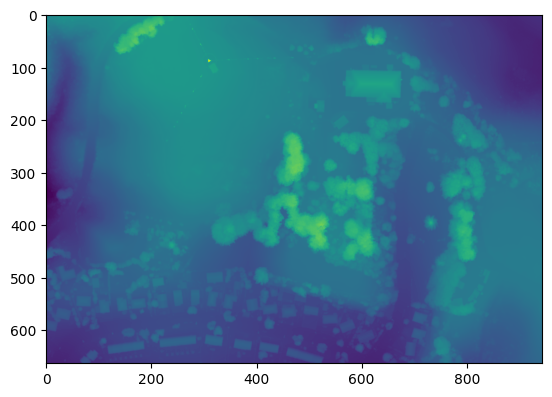

In [24]:
single_rband_visualizer(
    root=output_path,
    dem_path=new_raster_dsm_path,
    visualize=True
)

### 3 - CHM Generation

In [25]:
DTMS_PATH = os.path.join(
    OUTPUT_PATH, "dtm/*"
    )
        
DSMS_PATH = os.path.join(
    OUTPUT_PATH, "dsm/*"
    )
        
CHM_OUTPUT_PATH = os.path.join(
     OUTPUT_PATH, "canopy"
    )
        
generate_chm(DTM_PATH = DTMS_PATH,
                DSM_PATH = DSMS_PATH,
                OUTPUT_PATH = CHM_OUTPUT_PATH,
                save_png=True)

. . . ExtractinG Model Files . . .
 Extracted DTM:  DTM-1.tif
 Extracted DSM:  DSM Wellington (GREATER) .tif
. . . ExtractinG Model Files . . .
 Extracted DTM:  DTM-0.tif
 Extracted DSM:  DSM Wellington (GREATER) .tif


In [26]:
image_chm = cv2.imread(
    "/home/metin/Desktop/workshop/carbon/carbon.v5/outputs/canopy/png/DTM-0.tif DSM Wellington (GREATER) .tif.png"
)

In [104]:
KERNEL = np.array([
    [0, -1, 0],
    [-1, 7.6, -1],
    [0, -1, 0]
])
sharpened_chm = cv2.filter2D(image_chm, -1, KERNEL)
simple_chm = cv2.blur(sharpened_chm, (1,1))
gray_chm = cv2.cvtColor(sharpened_chm, cv2.COLOR_BGRA2GRAY)

blurred_chm = cv2.GaussianBlur(gray_chm, (1,1), 0)
bilateral_chm = cv2.bilateralFilter(gray_chm, 1,1,1)
simple_chm = cv2.blur(gray_chm, (1,1))

median_chm = cv2.medianBlur(gray_chm, ksize=1)


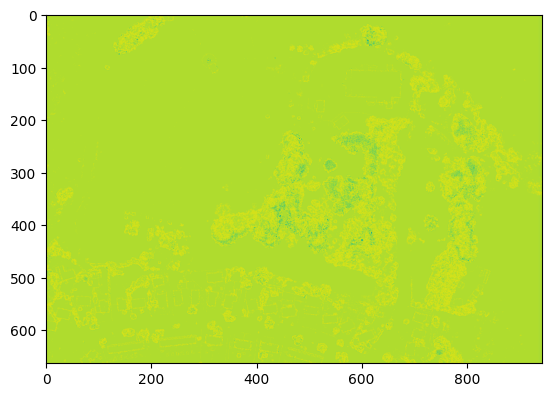

In [105]:
plt.imshow(bilateral_chm)
plt.show()

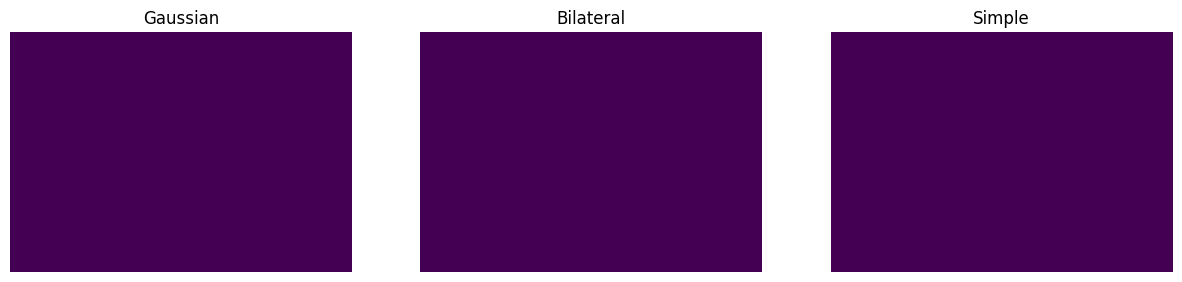

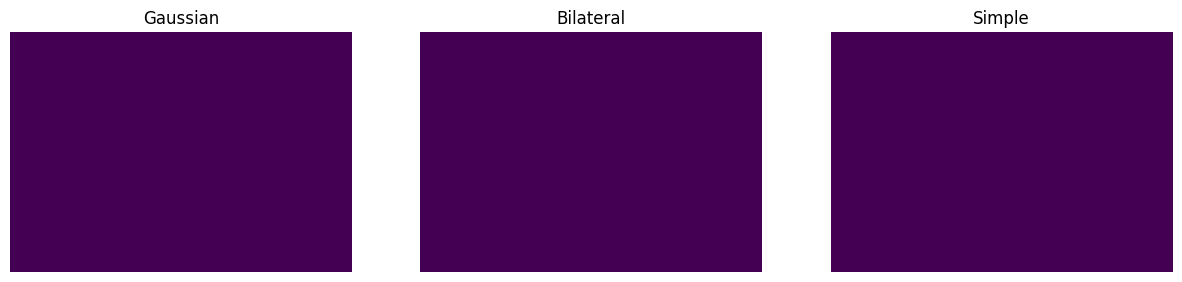

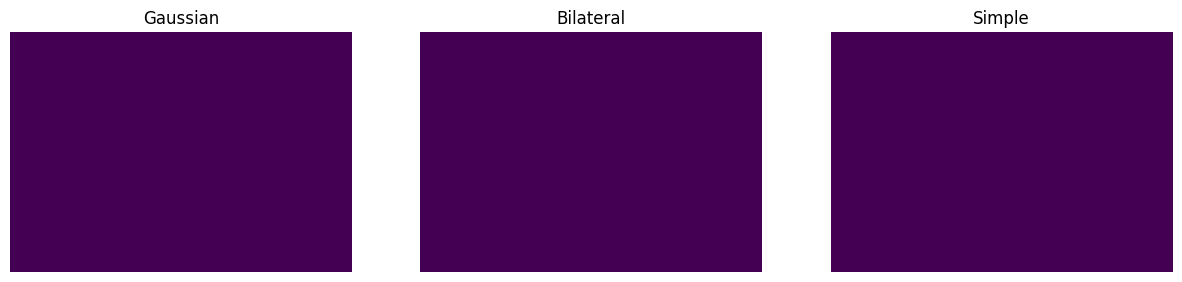

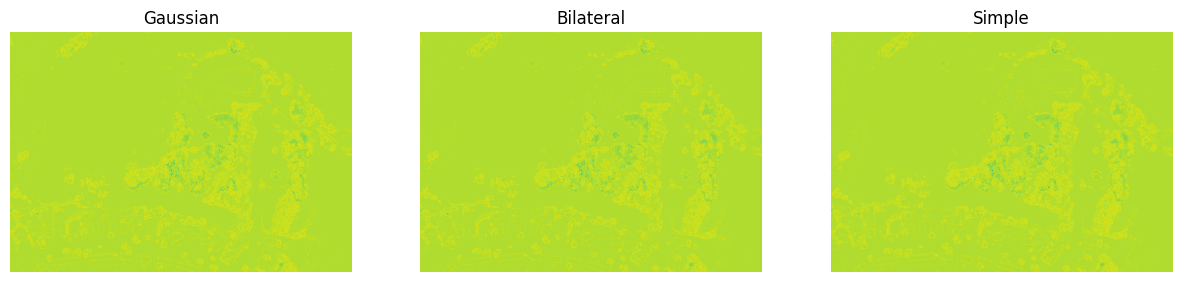

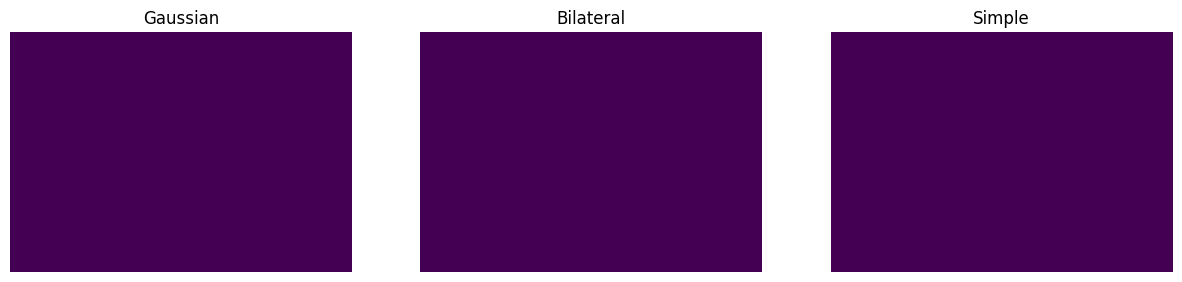

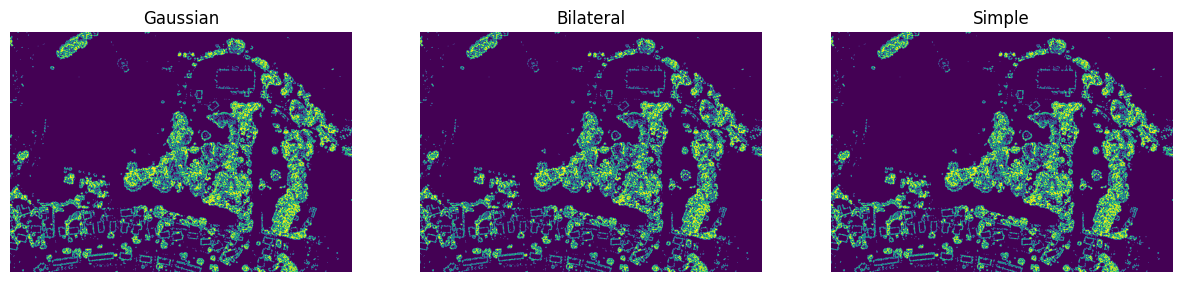

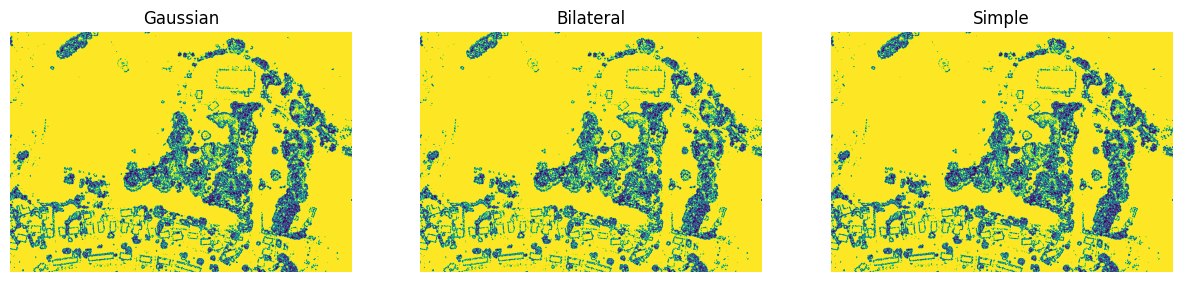

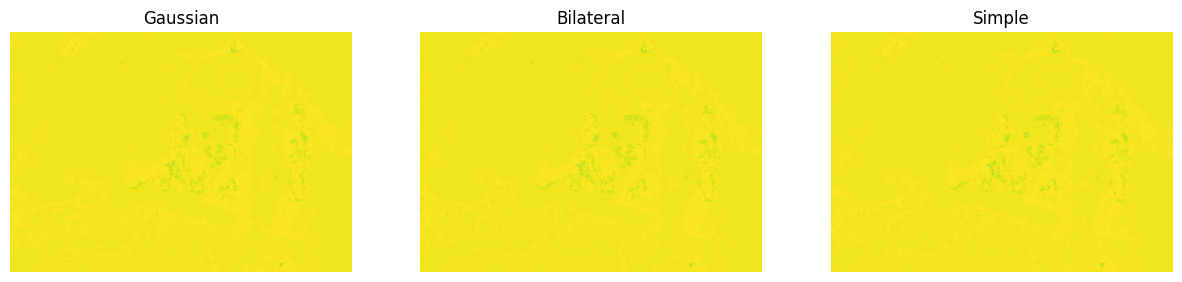

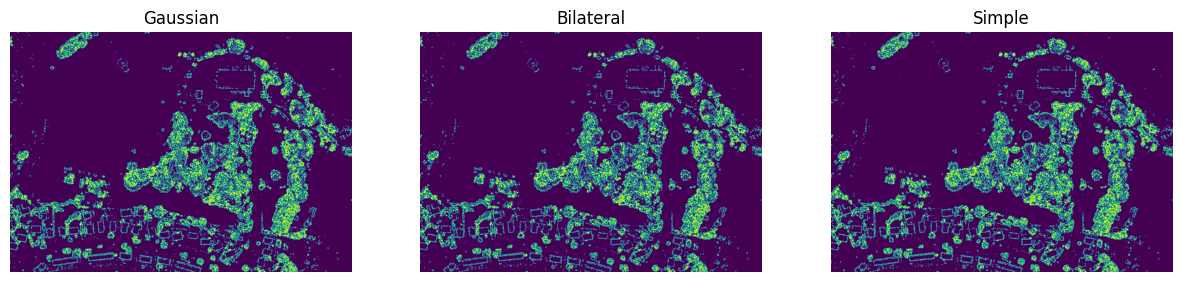

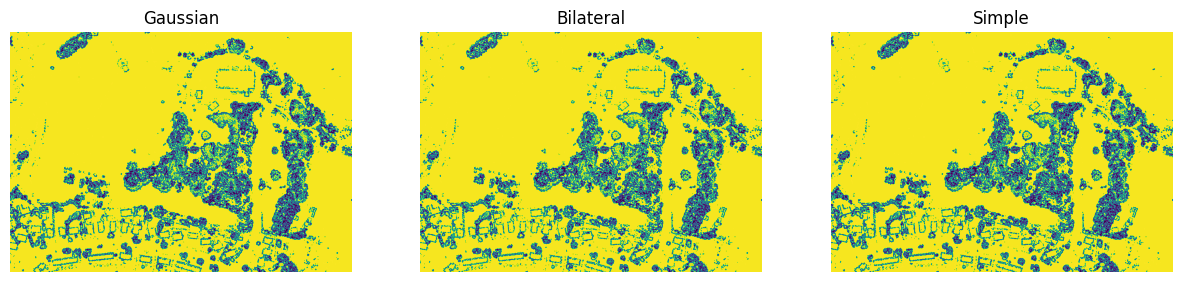

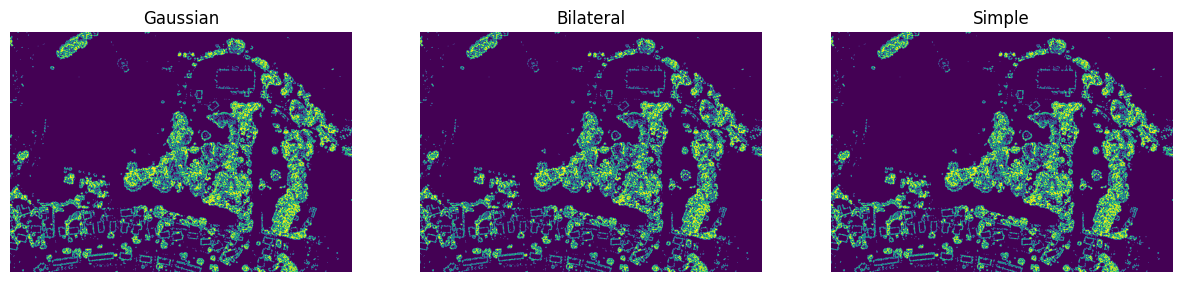

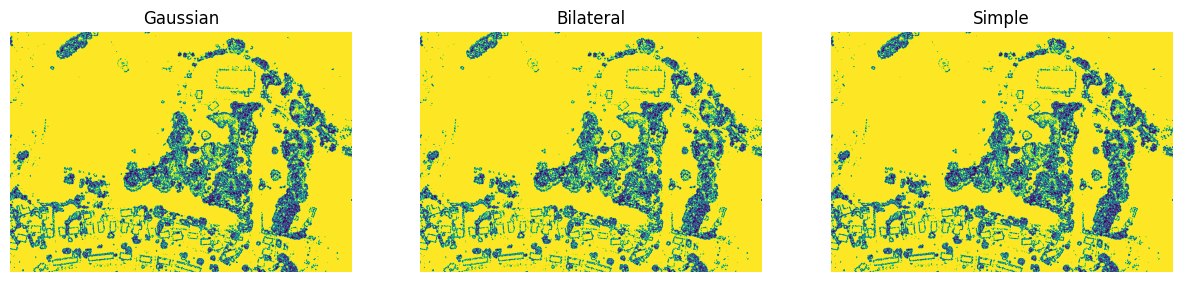

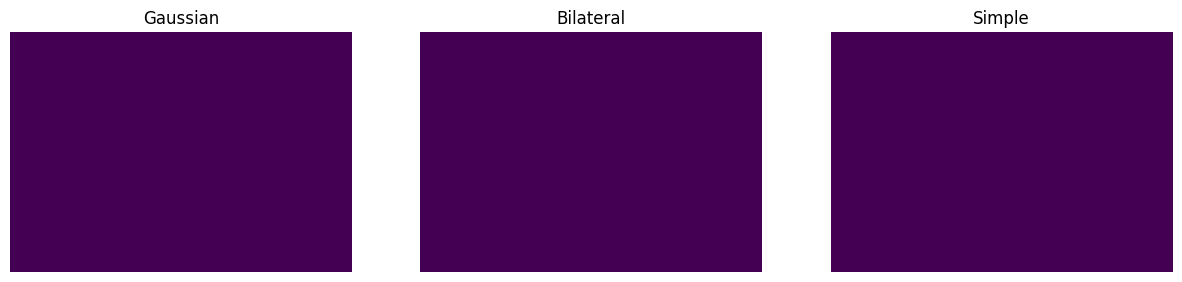

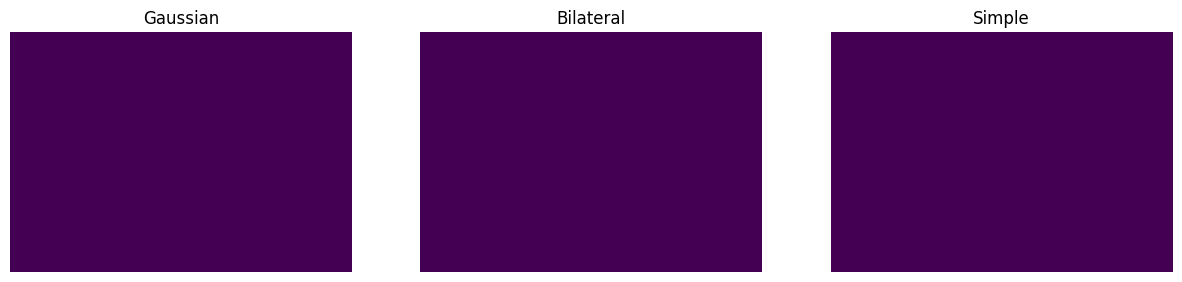

In [106]:
methods = [
	("THRESH_BINARY", 		cv2.THRESH_BINARY),
	("THRESH_BINARY_INV", 	  cv2.THRESH_BINARY_INV),
	("THRESH_TRUNC", 	   cv2.THRESH_TRUNC),
	("THRESH_TOZERO", 		 cv2.THRESH_TOZERO),
	("THRESH_TOZERO_INV", 		cv2.THRESH_TOZERO_INV),
 	("OTSU + THRESH_BINARY", 	 (cv2.THRESH_BINARY + cv2.THRESH_OTSU)),
 	("OTSU + THRESH_BINARY_INV", (cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)),
 	("OTSU + THRESH_TRUNC", 	 (cv2.THRESH_TRUNC + cv2.THRESH_OTSU)),
 	("OTSU + THRESH_TOZERO", 	 (cv2.THRESH_TOZERO + cv2.THRESH_OTSU)),
 	("OTSU + THRESH_TOZERO_INV", (cv2.THRESH_TOZERO_INV + cv2.THRESH_OTSU)),
 	("OTSU + ADAPTIVE_THRESH_MEAN_C", (cv2.ADAPTIVE_THRESH_MEAN_C + cv2.THRESH_OTSU)),
 	("OTSU + ADAPTIVE_THRESH_GAUSSIAN_C", (cv2.ADAPTIVE_THRESH_GAUSSIAN_C + cv2.THRESH_OTSU)),
	("ADAPTIVE_THRESH_MEAN_C", (cv2.ADAPTIVE_THRESH_MEAN_C)),
	("ADAPTIVE_THRESH_GAUSSIAN_C", (cv2.ADAPTIVE_THRESH_GAUSSIAN_C))
 
  ]

# loop over the threshold methodsz
for (threshName, threshMethod) in methods:
    fig, axs = plt.subplots(1, 3, figsize=(15,7))
    
    
    plt.subplot(1,3,1), plt.title("Gaussian"), plt.axis('off')
    thresh1 = cv2.threshold(blurred_chm, 0, 255, threshMethod)[1]
    plt.imshow(thresh1)
    
    plt.subplot(1,3,2), plt.title("Bilateral"), plt.axis('off')
    thresh2 = cv2.threshold(bilateral_chm, 0, 255, threshMethod)[1]
    plt.imshow(thresh2)
    
    plt.subplot(1,3,3), plt.title("Simple"), plt.axis('off')
    thresh3 = cv2.threshold(simple_chm, 0, 255, threshMethod)[1]
    plt.imshow(thresh3)
    

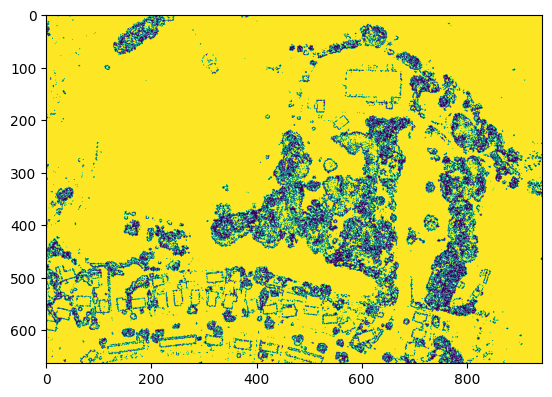

In [122]:
BEST = cv2.threshold(bilateral_chm, 0, 255,
                     (cv2.ADAPTIVE_THRESH_GAUSSIAN_C + cv2.THRESH_OTSU))[1]

FINAL = cv2.bilateralFilter(BEST, 6, 75, 65)
FINAL2 = cv2.GaussianBlur(BEST, (1,1), 0)
FINAL3 = cv2.medianBlur(BEST,ksize=1)


plt.imshow(FINAL3)
plt.show()

In [123]:
# find contours in the thresholded image
cnts = cv2.findContours(
        FINAL3.copy(),
            cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [133]:
new_cnts = [x for x in cnts if 75<=cv2.contourArea(x)<=20000]

In [134]:
len(cnts), len(new_cnts)

(7568, 187)

In [129]:

copy_image = image_chm.copy()
for i in cnts:
    M = cv2.moments(i)
    M['m00'] = 1
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv2.drawContours(copy_image, [i], -1, (255, 255, 255), 1)
        #cv2.circle(copy_image, (cx, cy), 2, (0, 0, 0), -1)

    cv2.imwrite("all_contours.png", copy_image)

    print(f"x: {cx} y: {cy}")
print("DONE.. .. . . ")

x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 393 y: 329
x: 0 y: 0
x: 0 y: 0
x: 1184 y: 988
x: 10219 y: 8911
x: 5924 y: 5613
x: 0 y: 0
x: 342 y: 328
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 2626 y: 2305
x: 5433 y: 4592
x: 1554 y: 1310
x: 786 y: 654
x: 0 y: 0
x: 0 y: 0
x: 3241 y: 3275
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 1290 y: 1298
x: 277 y: 324
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 648 y: 648
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 384 y: 322
x: 36747 y: 31274
x: 1534 y: 1320
x: 1524 y: 1296
x: 1530 y: 1292
x: 2557 y: 2905
x: 0 y: 0
x: 8611 y: 7096
x: 0 y: 0
x: 1540 y: 1284
x: 386 y: 322
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 0 y: 0
x: 1112 y: 945
x: 0 y: 0
x: 379 y: 312
x: 3810 y: 3130
x: 369 y: 311
x: 0 y: 0
x: 0 y: 0
x: 32997 y: 27448
x: 1506 y: 1252
x: 4121 y: 3424
x: 4120 y: 3385
x: 1500 y: 1232
x: 1498 y

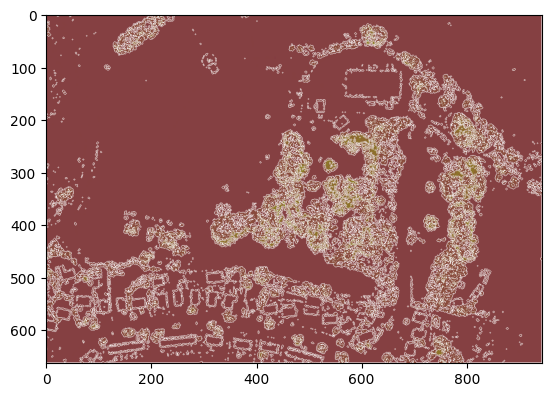

In [130]:
plt.imshow(copy_image)
plt.show()

In [135]:
# create hull array for convex hull points
hull = []
 
# calculate points for each contour
for i in range(len(new_cnts)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(new_cnts[i], False))

print(len(hull))

187


In [136]:
# Calculate and print areas:
for i in range(len(new_cnts)):
    cnts_area = cv2.contourArea(new_cnts[i])
    print("Area of hull", i + 1, ":", cnts_area)

Area of hull 1 : 124.5
Area of hull 2 : 312.5
Area of hull 3 : 82.5
Area of hull 4 : 76.5
Area of hull 5 : 286.5
Area of hull 6 : 80.0
Area of hull 7 : 157.0
Area of hull 8 : 160.0
Area of hull 9 : 138.0
Area of hull 10 : 89.5
Area of hull 11 : 86.0
Area of hull 12 : 188.0
Area of hull 13 : 247.5
Area of hull 14 : 136.0
Area of hull 15 : 101.5
Area of hull 16 : 313.0
Area of hull 17 : 339.5
Area of hull 18 : 154.0
Area of hull 19 : 169.0
Area of hull 20 : 122.0
Area of hull 21 : 163.0
Area of hull 22 : 438.0
Area of hull 23 : 91.5
Area of hull 24 : 128.5
Area of hull 25 : 325.5
Area of hull 26 : 124.5
Area of hull 27 : 173.0
Area of hull 28 : 400.5
Area of hull 29 : 266.0
Area of hull 30 : 132.0
Area of hull 31 : 352.0
Area of hull 32 : 328.0
Area of hull 33 : 260.0
Area of hull 34 : 183.0
Area of hull 35 : 90.5
Area of hull 36 : 930.5
Area of hull 37 : 216.5
Area of hull 38 : 323.0
Area of hull 39 : 92.0
Area of hull 40 : 372.5
Area of hull 41 : 199.5
Area of hull 42 : 92.5
Area of hu

In [139]:
# create an empty black image
drawing = np.zeros((FINAL.shape[0], FINAL.shape[1], 3), np.uint8)
 
# draw contours and hull points
for i in range(len(new_cnts)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    #cv2.drawContours(drawing, new_cnts, i, color_contours, 1, 8)
    # draw ith convex hull object
    cv2.drawContours(drawing, hull, i, color, 1, 8)
cv2.imwrite("just_hulls.png", drawing)

True